# Clustering
Unsupervised machine learning. Discrete classification. 

Links
* [Tutorial](https://matteucci.faculty.polimi.it/Clustering/tutorial_html/index.html) from Italy
* [sklearn](https://scikit-learn.org/stable/modules/clustering.html) index of all algorithms
* [sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) comparison on toy datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
#np.random.seed(0)

In [2]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

In [3]:
COLORS = np.array([
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00"
])

## Hierarchical clustering: Agglomerative clustering.
Bottom-up. Scales well. Works with any distance, even non-Euclidean. Can choose #clusters interactively.  

Clustering metrics: single-linkage clustering (min), complete-linkage clustering (max), average-linkage clustering. Ward uses centroids and SSE; it is similar to ANOVA and to the K-means objective function in that it minimizes intra vs inter group variance.

See: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) AgglomerativeClustering. Can set goal by #clusters or distance threshold. Attributes include #clusters, #leaves, #features used, and #connected components.    
See also: [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html#sklearn.cluster.FeatureAgglomeration) FeatureAgglomeration can cluster features for dimensionality reduction.

In [4]:
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.AgglomerativeClustering()
    if num_clusters is not None:
        alg = cluster.AgglomerativeClustering(num_clusters)  
        ## with no setting, it converges on 2
    alg.fit(X)
    ypred = alg.labels_
    print('#clusters',alg.n_clusters_,'cluster assignments per point',alg.labels_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

#clusters 2 cluster assignments per point [1 1 1 0 0 0]


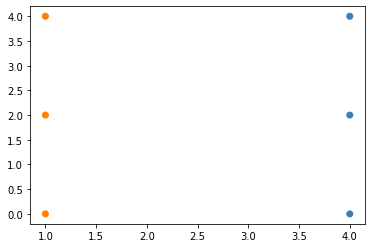

In [5]:
# Simple example from docs with 2 clusters obviously.
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
Y = [0,0,0,1,1,1]
make_clusters( (X,Y) )

#clusters 2 cluster assignments per point [0 1 0 ... 1 0 1]


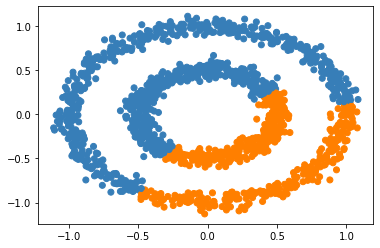

In [6]:
make_clusters(noisy_circles)

#clusters 3 cluster assignments per point [2 2 2 ... 2 1 1]


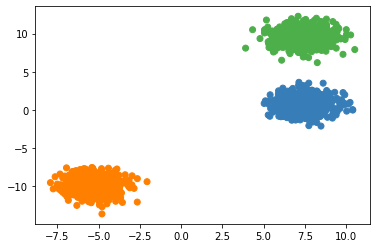

In [7]:
make_clusters(blobs,3)  # better than 2

#clusters 5 cluster assignments per point [2 1 4 ... 3 4 2]


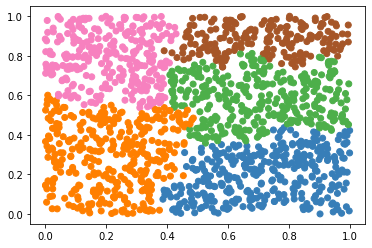

In [8]:
make_clusters(no_structure,5)

## Partition clustering: K-Means Clustering  
K-means finds a local optimum. 
If it merges two real clusters, finding the optimum becomes hopeless. 
That's why it is recommended to try several reruns with different random initializers.

See [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans) Kmeans.
The sklearn initializer can be 'random', 'kmeans++', or an array.
The array can have means & weights for purpose of inertia calculation.
Random is fastest but worst performer. 
The sklearn class runs K-means 10 times (settable)
using different random seeds each time.
In addition to the standard Lloyd algorithm, 
sklearn can run the Elkan optimization. 

Kmeans++ chooses random points that are not close to each other
and are reflective of the data distributon.
Kmeans++ has guarrantee of coming within log() of the optimum.
See [kmeans++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf) from Stanford.

For large data, use sklearn [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans) which re-estimates means on small batches rather than all the data.

In [9]:
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.KMeans()  # default = 8
    if num_clusters is not None:
        alg = cluster.KMeans(num_clusters)  
    alg.fit(X)
    ypred = alg.labels_
    print('iterations',alg.n_iter_,',cluster centers:\n',alg.cluster_centers_)
    print('cluster assignments per point',alg.labels_)
    print('SSE (optionally weighted)',alg.inertia_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

iterations 12 ,cluster centers:
 [[0.20287016 0.80154716]
 [0.77149965 0.25385848]
 [0.76948775 0.78444924]
 [0.46314409 0.54501376]
 [0.239406   0.22163905]]
cluster assignments per point [3 3 2 ... 0 2 3]
SSE (optionally weighted) 52.09420253655558


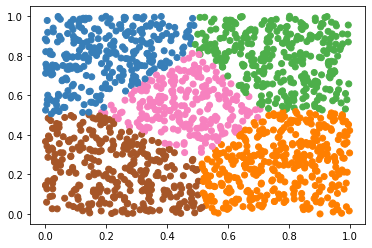

In [10]:
make_clusters(no_structure,5)

iterations 21 ,cluster centers:
 [[0.65729317 0.14867011]
 [0.45800319 0.55799874]
 [0.74509525 0.83757066]
 [0.20320286 0.24619606]
 [0.19212967 0.80493519]
 [0.84453443 0.42332083]]
cluster assignments per point [1 1 2 ... 4 2 1]
SSE (optionally weighted) 43.041578905342405


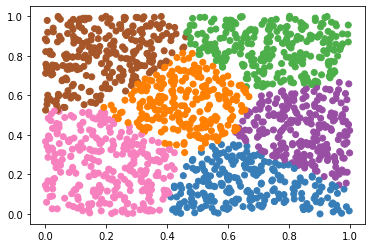

In [11]:
make_clusters(no_structure,6)

### Bisecting Kmeans

This algorithm starts with one cluster then iteratively cut one in 2 (or n). 
There are various strategies for choosing the next cluster to split.

Coming soon: [sklearn](https://scikit-learn.org/dev/modules/generated/sklearn.cluster.BisectingKMeans.html) cluster.BisectingKmeans. 
For now, you must install developer pre-release, ver 1.1. 
This class has the same fields and methods as Kmeans. 
Set the strategy to bisect the cluster with max #points or max inertia=SSE. 
This class never generates empty clusters. 
See [sklearn](https://scikit-learn.org/dev/auto_examples/cluster/plot_bisect_kmeans.html) to compare Kmeans with Bisecting Kmeans.

Bisecting vs regular Kmeans  
Pros  
* Less computation since it works on fewer points per iteration. More efficient for large datasets.  
* Clusters more likely correspond to true hierachy. Fewer unrelated clusters. 
* Better results compared to Kmeans(initializer=random). 

Cons
* Won't work for generating 2 clusters.  
* Worse results compared to Kmeans(initializer=k-means++).  


## Homegrown K-means

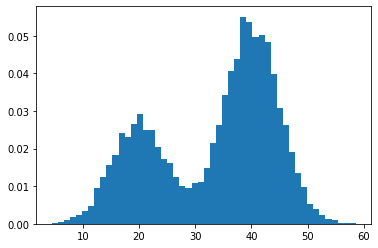

In [12]:
# Straight from the Mastery site.
# Construct a bimodal from two Gaussian processes.
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [49]:
def is_closer(point,this_mean,that_mean):
    return abs(point-this_mean) < abs(point-that_mean)
def sse(vector,mean):
    err=vector-mean
    se=np.square(err)
    sse=sum(se)
    return int(sse)
def assign_clusters(mean1,mean2,data):
    clust1=np.asarray([x for x in data if is_closer(x,mean1,mean2)])
    clust2=np.asarray([x for x in data if is_closer(x,mean2,mean1)])
    print('Cluster sizes:',len(clust1),len(clust2))
    sse1=sse(clust1,mean1)
    sse2=sse(clust2,mean2)
    print('Cluster SSE:',sse1,sse2)
    print('Cluster stdev:',np.sqrt(sse1)/len(clust1),np.sqrt(sse2)/len(clust2))
    return clust1,clust2
def recompute_means(clust1,clust2):
    mean1=np.mean(clust1)
    mean2=np.mean(clust2)
    print('Means:',mean1,mean2)
    return mean1,mean2
def iterative_2_means_delta(mean1,mean2,data,delta):
    """Iterate till the means change by less than delta."""
    # This code is for 1-dimensional means, so diff=mean1-mean2.
    # For matrix means, use np.linalg.norm(diff)
    # i.e. sqrt of sum of squares of differences per dimension.
    clust1,clust2=assign_clusters(mean1,mean2,data)
    prev1=mean1
    prev2=mean2
    diff=delta+1
    while diff>delta:
        print()
        mean1,mean2=recompute_means(clust1,clust2)
        clust1,clust2=assign_clusters(mean1,mean2,data)
        diff=max(abs(mean1-prev1),abs(mean2-prev2)) # L-inf norm
        diff=np.sqrt((mean1-prev1)**2+(mean2-prev2)**2) # L2 norm
        print('Diff:',diff,'Delta:',delta)
        prev1=mean1
        prev2=mean2
    return mean1,mean2

In [50]:
# Choose fair not-quite-random initializers, k=2.
mean1 = 29
mean2 = 30
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
X = np.asarray(X)
print('Initial means:',mean1,mean2)
new1,new2=iterative_2_means_delta(mean1,mean2,X,0.01)

Initial means: 29 30
Cluster sizes: 3018 5982
Cluster SSE: 313643 760701
Cluster stdev: 0.1855660674423961 0.1458010276019176

Means: 19.948473036756155 40.19417320682561
Cluster sizes: 3074 5926
Cluster SSE: 71802 132980
Cluster stdev: 0.08716947042301604 0.06153631946007989
Diff: 13.632729284229606 Delta: 0.01

Means: 20.127741865096954 40.29250038050166
Cluster sizes: 3086 5914
Cluster SSE: 72906 131686
Cluster stdev: 0.08749549931383566 0.06136044249617814
Diff: 0.20446404548918232 Delta: 0.01

Means: 20.166675289576705 40.3131004065822
Cluster sizes: 3088 5912
Cluster SSE: 73104 131480
Cluster stdev: 0.08755748505762273 0.06133317149342133
Diff: 0.04404739057242284 Delta: 0.01

Means: 20.17319105593247 40.31651247757804
Cluster sizes: 3089 5911
Cluster SSE: 73205 131378
Cluster stdev: 0.08758958409759618 0.06131974833163774
Diff: 0.007355096170924075 Delta: 0.01
